In [1]:
from matplotlib import pyplot as plt
from matplotlib import animation
from numpy import genfromtxt
import seaborn as sns
sns.set()
import numpy as np
import pickle
import scipy.stats as stats
import pandas as pd
import os
import cv2

In [2]:
from get_entropy_values import get_frame_entropy_dist
from get_entropy_values import get_one_entropy_val
from get_entropy_values import write_animated_distribution

In [3]:
# videos are stored elsewhere; this is the path to get to them
vid_path = '/Users/sydney/Documents/Research/SCCN/street_view_vids'
# and the path to get back here
return_path = '/Users/sydney/Documents/Research/SCCN/street_view'

## 1). Overall entropy
### First, looking at the average entropy value per frame for the entire day and night videos

In [4]:
# import full set of ave entropies
day_ave_entropy = pickle.load(open('day_ave_entropy.p','rb'))
night_ave_entropy = pickle.load(open('night_ave_entropy.p','rb'))

In [3]:
# some stats about that 
# this website told me to check the variance so I am
print('Day Mean:   ' + str(np.mean(day_ave_entropy)))
print('Night Mean: ' + str(np.mean(night_ave_entropy)))
print("")
print('Day Variance:   ' + str(np.var(day_ave_entropy)))
print('Night Variance: ' + str(np.var(night_ave_entropy)))


Day Mean:   5.012844093587958
Night Mean: 4.547056894595306

Day Variance:   0.032629893648885924
Night Variance: 0.05180302717540263


Both the mean and the variance for day vs. night look different, which is what we expected.

Next, we'll plot the distribution.

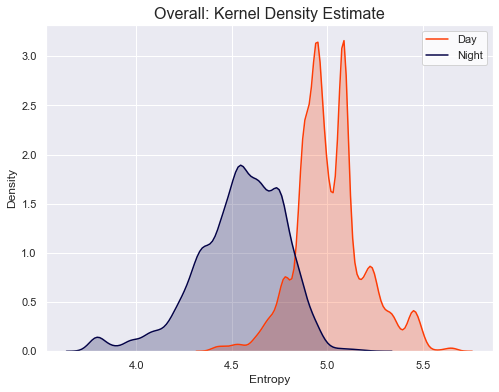

In [4]:
# plotting the kernel density estimate (which is basically a smooth histogram)
fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(day_ave_entropy,  shade=True, color='xkcd:red orange', label='Day', legend=True)
sns.kdeplot(night_ave_entropy, shade=True, color='xkcd:night blue', label='Night', legend=True)

handles, labels = ax.get_legend_handles_labels()
ax.legend(facecolor='w')
plt.title("Overall: Kernel Density Estimate", fontsize=16)
ax.set_xlabel('Entropy')
ax.set_ylabel('Density')

fig.savefig('overall_entropy_kde.png', format='png') 

plt.show()

These distributions look pretty different, both in the spread and average (which we expected from the stats above). Interesting that the day distribution look like it's bimodal - wonder why that is?

Next, we'll do a t-test to see if this difference is statistically significant:

In [5]:
# t-test for difference between night and day ave entropy values
ave_ttest = stats.ttest_ind(a=day_ave_entropy, b=night_ave_entropy, equal_var=False)
print('-----Ave Entropy-----')
print('t-stat : ' + str(ave_ttest[0]))
print('p-value: ' + str(ave_ttest[1]))

-----Ave Entropy-----
t-stat : 178.09824981150638
p-value: 0.0


## 2) Analyzing Pilot03

In [11]:
# ave entropy vals per fixation
p03_day = pd.read_csv('pilot03_day_entropy_df.csv')
p03_night = pd.read_csv('pilot03_night_entropy_df.csv')

# get rid of index row (TODO: when generating df, exclude index)
p03_day = p03_day.drop(p03_day.columns[0], axis=1) 
p03_night = p03_night.drop(p03_night.columns[0], axis=1) 

For each fixation, I have the average entropy over the duration of that fixation, the start time and end time, as well as the total length of the duration

In [7]:
p03_day.head()

,Ave_Entropy,Start_Time,End_Time,Duration
0,6.094622,0.666373,1.032855,0.366482
1,5.838363,1.232762,1.599259,0.366497
2,5.926849,1.732531,2.509953,0.777422
3,5.991148,2.987515,3.342901,0.355386
4,6.272101,4.020370,4.720046,0.699676


Next, calculating some general statistics.

In [8]:
Day_Entropy = p03_day.Ave_Entropy.describe()
Night_Entropy = p03_night.Ave_Entropy.describe()
Day_Duration = p03_day.Duration.describe()
Night_Duration = p03_night.Duration.describe()

names = ["Day Entropy", "Night Entropy", "Day Duration", "Night Duration"]
p03_stats = pd.DataFrame([Day_Entropy, Night_Entropy, Day_Duration, Night_Duration], index=names)
p03_stats

,count,mean,std,min,25%,50%,75%,max
Day Entropy,339.0,5.468696,0.691669,3.106290,5.059487,5.637819,5.974679,6.667893
Night Entropy,259.0,5.471031,0.728618,2.740508,5.074989,5.606529,6.047210,6.614138
Day Duration,339.0,1.017260,1.140285,0.188800,0.388755,0.622000,1.166150,10.239700
Night Duration,259.0,0.953430,0.828620,0.199900,0.372050,0.655250,1.277200,5.652850


It appears that for both entropy and duration, the distributions are extremely similar.

Same goes for duration, although the day duration has a much higher maximum (I'm concerned it might be something wrong with the way I calculated the data....)

So, regardless of whether it's day or night, the subject's gaze is attracted to about the same level of entropy (note, though, that this is higher than the average entropy val for day or night), and has similar durations of fixations. 

Next, we'll plot the entropy and duration distributions:

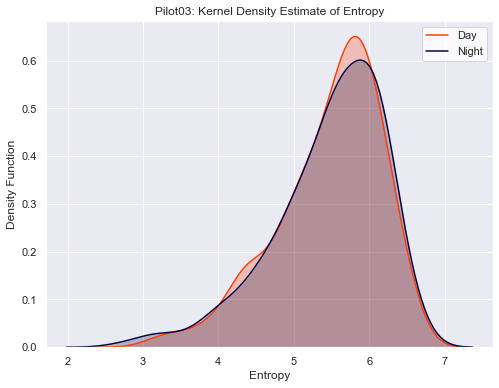

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(p03_day.Ave_Entropy, shade=True, color='xkcd:red orange', label='Day', legend=True)
sns.kdeplot(p03_night.Ave_Entropy, shade=True, color='xkcd:night blue', label='Night', legend=True)

handles, labels = ax.get_legend_handles_labels()
ax.legend(facecolor='w')
ax.set_xlabel('Entropy')
ax.set_ylabel('Density Function')

plt.title("Pilot03: Kernel Density Estimate of Entropy")
plt.show()

fig.savefig('p03_entropy_kde.png', format='png') 

As reflected in the stats dataframe, the distributions for day and night look about the same.

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(p03_day.Duration, shade=True, color='xkcd:red orange', label='Day', legend=True)
sns.kdeplot(p03_night.Duration, shade=True, color='xkcd:night blue', label='Night', legend=True)

handles, labels = ax.get_legend_handles_labels()
ax.legend(facecolor='w')
ax.set_xlabel('Duration')
ax.set_ylabel('Density Function')

plt.title("Pilot03: Kernel Density Estimate of Duration")
plt.show()


# fig.savefig('p03_duration_kde.png', format='png') 

Same goes for durations of fixation; although day looks to have a higher max (again, looks like outliers).

Just to be sure there's nothing significant, we'll do some t-tests:

In [12]:
# t-tests

# p03 day vs night entropy
p03_entropy_ttest = stats.ttest_ind(a=p03_day.Ave_Entropy, b=p03_night.Ave_Entropy, equal_var=True)

# p03 day vs night duration
p03_duration_ttest = stats.ttest_ind(a=p03_day.Duration, b=p03_night.Duration, equal_var=False)

# average vs p03 entropy (day condition)
ave_vs_p03_day_ttest = stats.ttest_ind(a=p03_day.Ave_Entropy, b=day_ave_entropy)
# average vs p03 entropy (night condition)
ave_vs_p03_night_ttest = stats.ttest_ind(a=p03_night.Ave_Entropy, b=night_ave_entropy)


print('-----P03 Entropy: Day vs. Night-----')
print('t-stat : ' + str(p03_entropy_ttest[0]))
print('p-value: ' + str(p03_entropy_ttest[1]))
print("")
print('-----P03 Duration: Day vs. Night-----')
print('t-stat : ' + str(p03_duration_ttest[0]))
print('p-value: ' + str(p03_duration_ttest[1]))
print("")
print('-----Ave vs. P03 Entropy (Day)-----')
print('t-stat : ' + str(ave_vs_p03_day_ttest[0]))
print('p-value: ' + str(ave_vs_p03_day_ttest[1]))
print("")
print('-----Ave vs. P03 Entropy (Night)-----')
print('t-stat : ' + str(ave_vs_p03_night_ttest[0]))
print('p-value: ' + str(ave_vs_p03_night_ttest[1]))

-----P03 Entropy: Day vs. Night-----
t-stat : -0.039971171287423495
p-value: 0.9681294954314719

-----P03 Duration: Day vs. Night-----
t-stat : 0.7925305045843941
p-value: 0.42836751081269253

-----Ave vs. P03 Entropy (Day)-----
t-stat : 40.33817644370771
p-value: 0.0

-----Ave vs. P03 Entropy (Night)-----
t-stat : 58.681579040749384
p-value: 0.0


So, as suspected, there is no significant difference between the entropy values or durations between the night and day conditions for Pilot03. However, there was a significant difference between the average entropy and p03's entropy values for the day and night conditions (I don't think this is the best way to calculate it, though - the averages have greater than 10,000 samples while p03's have less than 500...ideas for other tests to use here?).

I also tested if there was a correlation between entropy duration of fixations:

In [13]:
# correlation between duration of fixation and entropy?
print(np.corrcoef([p03_day.Ave_Entropy, p03_day.Duration]))
print(np.corrcoef([p03_night.Ave_Entropy, p03_night.Duration]))

[[ 1.         -0.10966762]
 [-0.10966762  1.        ]]
[[1.         0.08613675]
 [0.08613675 1.        ]]


So, not looking good for correlation. I plotted it anyway. 

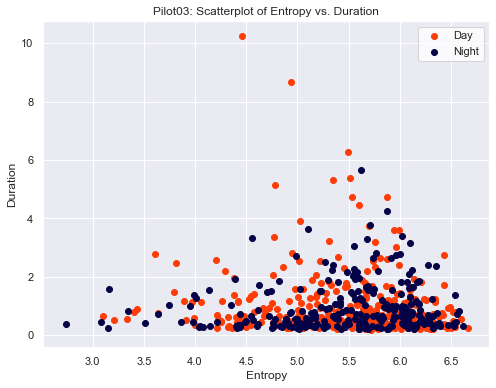

In [14]:
fig, ax = plt.subplots(figsize=(8,6))

plt.scatter(p03_day.Ave_Entropy, p03_day.Duration, color='xkcd:red orange', label='Day')
plt.scatter(p03_night.Ave_Entropy, p03_night.Duration, color='xkcd:night blue', label='Night')

ax.legend(facecolor='w')
ax.set_xlabel('Entropy')
ax.set_ylabel('Duration')

plt.title("Pilot03: Scatterplot of Entropy vs. Duration")
plt.show()

fig.savefig('p03_ent_vs_duration.png', format='png') 

Conclusions: for this individual, there was no significant difference between the night and day conditions in regards to entropy or length of fixations/duration. However, there was a difference between where the subject fixated (on areas of high entropy, regardless of condition) and the average entropy per frame.

Perhaps I can try doing more of a paired t-test, directly comparing the frames associated with fixations?

Also, I've been using the real entropy values for this, but do we want to used the normed values for any of these calculations?

Any other tests/visualizations we should explore?

And for the hell of it, average entropy value for the entire videos:

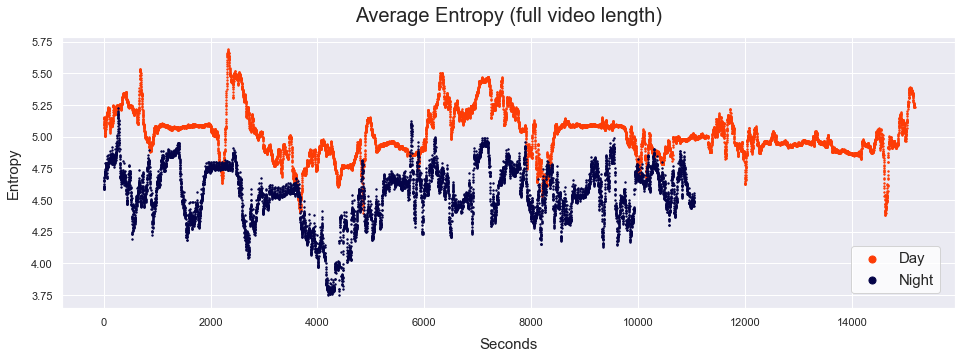

In [16]:
# scatter plot
fig, axes = plt.subplots(figsize=(16,5))

# plt.setp(axes, xticks=np.arange(0,1050,50), xticklabels=np.round(np.arange(0,1050,50)/30, decimals=2), yticks=np.arange(0.5,0.8,0.0125))
axes.set_title('Average Entropy (full video length)', size=20, pad = 15)

axes.set_xlabel('Seconds', size=15, labelpad=10)
axes.set_ylabel('Entropy', size=15, labelpad = 10)

axes.scatter(range(0,len(day_ave_entropy)), day_ave_entropy, s=2, color='xkcd:red orange', label='Day')
axes.scatter(range(0,len(night_ave_entropy)), night_ave_entropy, s=2, color='xkcd:night blue', label='Night')

plt.legend(loc='lower right', facecolor='white', borderaxespad=1, prop={'size': 15}, markerscale=5) 
#plt.tight_layout(pad=10.0)

fig.savefig('ave_entropy_full.png', format='png') 

plt.show()

### Looking at Luminance

Same as entropy analyses, but with luminance (only first minute) 

In [28]:
# import luminance vals
day_lum = pickle.load(open('day_ave_lum_1min.p', 'rb'))
night_lum = pickle.load(open('night_ave_lum_1min.p', 'rb'))

In [29]:
print('Day Mean:   ' + str(np.mean(day_lum)))
print('Night Mean: ' + str(np.mean(night_lum)))
print("")
print('Day Variance:   ' + str(np.var(day_lum)))
print('Night Variance: ' + str(np.var(night_lum)))

Day Mean:   0.4709669264787879
Night Mean: 0.2721884231431122

Day Variance:   0.0001839443634535402
Night Variance: 0.0011650618407260517


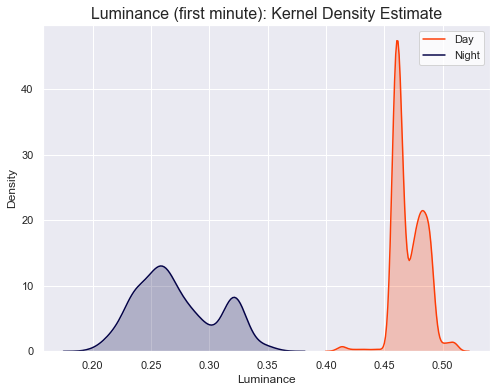

In [27]:
# plotting the kernel density estimate (which is basically a smooth histogram)
fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(day_lum,  shade=True, color='xkcd:red orange', label='Day', legend=True)
sns.kdeplot(night_lum, shade=True, color='xkcd:night blue', label='Night', legend=True)

handles, labels = ax.get_legend_handles_labels()
ax.legend(facecolor='w')
plt.title("Luminance (first minute): Kernel Density Estimate", fontsize=16)
ax.set_xlabel('Luminance')
ax.set_ylabel('Density')

# fig.savefig('overall_entropy_kde.png', format='png') 

plt.show()

### Going to look at the range and where the fixations are in the range.

In [4]:
# import minimums, maximums
day_max_ent = genfromtxt('downtown_day_max_entropy.csv', delimiter=',')
day_max_ent = day_max_ent[:300]
night_max_ent = genfromtxt('downtown_night_max_entropy.csv', delimiter=',')
night_max_ent = night_max_ent[:300]
day_min_ent = pickle.load(open('day_min_vals.p', 'rb'))
day_min_ent = day_min_ent[:300]
night_min_ent = pickle.load(open('night_min_vals_300.p', 'rb'))
night_min_ent = night_min_ent[:300]

In [30]:
day_900_fix = pickle.load(open('pilot03_day_900_fix.p', 'rb'))
night_900_fix = pickle.load(open('pilot03_night_900_fix.p', 'rb'))

In [7]:
# # get fixations  # tODO: need this?
# def get_fix_ent_vals(which_video, subNum):

#     os.chdir(return_path)
    
#     fix_file = subNum + '_' + which_video + '_fix.csv'
#     fix = genfromtxt(fix_file, delimiter=',')

#     entropies = np.zeros(900)
#     for i in range(0,900):
#         if fix[0, i]:
#             frame = int(fix[3, i])
#             x = fix[4, i]
#             y = fix[5, i]
#             ent_val = get_one_entropy_val(which_video,subNum,frame,x,y)
#         else:
#             entropies[i] = np.NaN
            
#     return entropies

# day_900_fix = get_fix_ent_vals('day', 'pilot03')
# night_900_fix = get_fix_ent_vals('night', 'pilot03')   

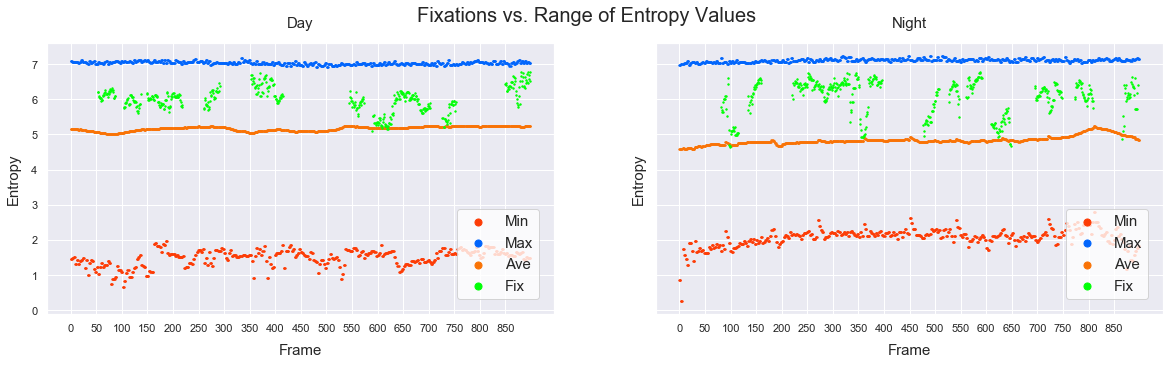

In [36]:
num_samples = 900

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20,5))

plt.setp(ax, xticks=np.arange(0,900,50), yticks=np.arange(0,7.5,1))
# ax.set_title('Visualizing Fixations within Range, first {this_many} frames'.format(this_many=num_frames), size=20, pad = 15)

# ax.set_xlabel('Frame', size=15, labelpad=10)
# ax.set_ylabel('Entropy', size=15, labelpad = 10)

x_vals = range(0,num_samples)

##### DAY ####
# minimums 
ax[0].scatter(x_vals, np.repeat(day_min_ent, 3), s=2, color='xkcd:red orange', label='Min')
# maximums
ax[0].scatter(x_vals, np.repeat(day_max_ent, 3), s=2, color='xkcd:bright blue', label='Max')
# ave
ax[0].scatter(x_vals, np.repeat(day_ave_entropy[0:300], 3), s=2, color='xkcd:orange', label='Ave')
# fix
ax[0].scatter(x_vals, day_900_fix, s=2, color='xkcd:bright green', label='Fix')

ax[0].legend(loc='lower right', facecolor='white', borderaxespad=1, prop={'size': 15}, markerscale=5) 

ax[0].set_title('Day', size=15, pad = 15)
ax[0].set_xlabel('Frame', size=15, labelpad=10)
ax[0].set_ylabel('Entropy', size=15, labelpad = 10)

##### NIGHT ####
# minimums 
ax[1].scatter(x_vals, np.repeat(night_min_ent, 3), s=2, color='xkcd:red orange', label='Min')
# maximums
ax[1].scatter(x_vals, np.repeat(night_max_ent, 3), s=2, color='xkcd:bright blue', label='Max')
# ave
ax[1].scatter(x_vals, np.repeat(night_ave_entropy[0:300], 3), s=2, color='xkcd:orange', label='Ave')
# fix
ax[1].scatter(x_vals, night_900_fix, s=2, color='xkcd:bright green', label='Fix')

ax[1].legend(loc='lower right', facecolor='white', borderaxespad=1, prop={'size': 15}, markerscale=5) 

ax[1].set_title('Night', size=15, pad = 15)
ax[1].set_xlabel('Frame', size=15, labelpad=10)
ax[1].set_ylabel('Entropy', size=15, labelpad = 10)

plt.suptitle('Fixations vs. Range of Entropy Values', size=20)
fig.savefig('p03_range.png', format='png') 

plt.show()


In [28]:
# ave_entropy = []
# count = 0
# for each in p03_day_ent_df[0]:
#     os.chdir(return_path)
#     ent_val = get_one_entropy_val('day','pilot03',each['frame'],each['xcord'],each['ycord'])
#     ave_entropy = ave_entropy + ent_val
# print(ave_entropy/count)

In [13]:
ent_val

5.356560329991237

In [4]:
which_video = 'day'
subNum = 'pilot03'
frame_num = 18
index = 0
fix_file = subNum + '_' + which_video + '_fix.csv'
os.chdir(return_path)
fix = genfromtxt(fix_file, delimiter=',')
sns.set_style("white")

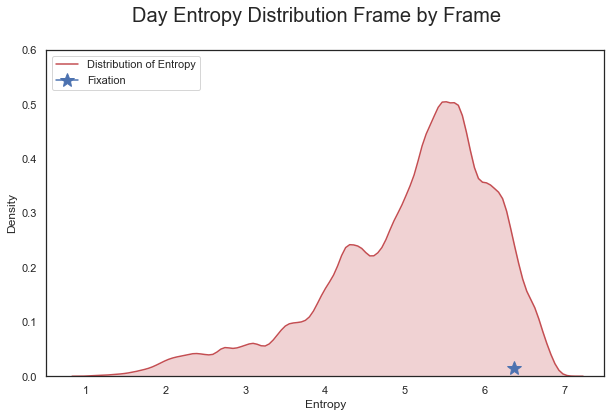

In [5]:
# init figure
fig, ax = plt.subplots(figsize=(10, 6))

plt.clf()
# set consistent lims so frame size doesn't change
plt.suptitle('{which} Entropy Distribution Frame by Frame'.format(which=which_video.capitalize()), size=20)
plt.xticks=np.arange(0,7.5,0.5)
plt.yticks=np.arange(0,0.6,0.05) 
# get frame number
frame_num = int(fix[3, 0])
# get distribution array
entropy_dist = get_frame_entropy_dist(which_video, 18)
# plot
sns.kdeplot(entropy_dist, shade=True, color='r', label='Distribution of Entropy', legend=True)
if fix[1, index]:
    # get entropy
    fix_ent = get_one_entropy_val(which_video, subNum, frame_num, fix[4, index], fix[5, index])
    # plot entropy
    point, = plt.plot(fix_ent, 0.015, color='b', marker='*', markersize=15)
    point.set_label('Fixation')
# plt.setp(ax, xticks=np.arange(0,7.5,0.5), yticks=np.arange(0,0.6,0.05), xlabel='Entropy',ylabel='Density')

ax.set_xlim(0.5, 7.5)
ax.set_ylim(0, 0.6)
plt.xlim(0.5, 7.5)
plt.ylim(0, 0.6)
# label axes/title
plt.xlabel('Entropy')
plt.ylabel('Density')
plt.legend(loc='upper left', facecolor='w')

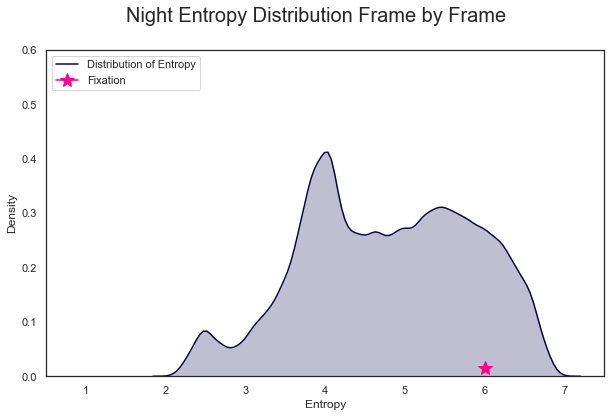

In [6]:
os.chdir(return_path)
write_animated_distribution('night', 'pilot03', 0, 1)

In [ ]:

os.chdir(return_path)
ent_dist = get_frame_entropy_dist('day',1)

In [ ]:
which_video = 'day'

fig, ax = plt.subplots(figsize=(10,6))  # TODO: change to nice size, idk what that is
plt.setp(ax, xticks=np.arange(0,7.5,0.5), yticks=np.arange(0,0.6,0.05))
ax.set_xlim(0.5,7.5)
ax.set_ylim(0,0.6)
ax.set_xlabel('Entropy')
ax.set_ylabel('Density')
ax.set_title('{which} Entropy Distribution Frame by Frame'.format(which=which_video.capitalize()), size=20)
 # this val comes from max of night/day
  # this is completely arbitrary i have no idea if it will work
sns.kdeplot(ent_dist, shade=True, color='r', label='Distribution of Entropy', legend=True)
os.chdir(return_path)
fix_ent = get_one_entropy_val('day', 'pilot03', 18, 0.4463802, 0.5167002)
# plot entropy
point, = plt.plot(fix_ent, 0.015, color='b', marker='*', markersize=15)
point.set_label('Fixation')

ax.legend(loc='upper left', facecolor='w')

In [ ]:
os.chdir(return_path)

subNum = 'pilot03'
which_video = 'day'
fix_file = subNum + '_' + which_video + '_fix.csv'
fix = genfromtxt(fix_file, delimiter=',')

int(np.around((fix[4, 0] * 540.0), decimals=0))

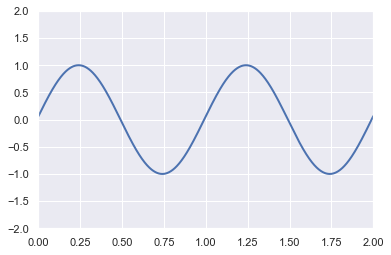

In [22]:
"""
Matplotlib Animation Example

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""


# # First set up the figure, the axis, and the plot element we want to animate
# fig = plt.figure()
# ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
# line, = ax.plot([], [], lw=2)

# # initialization function: plot the background of each frame
# def init():
#     line.set_data([], [])
#     return line,

# # animation function.  This is called sequentially
# def animate(i):
#     x = np.linspace(0, 2, 1000)
#     y = np.sin(2 * np.pi * (x - 0.01 * i))
#     line.set_data(x, y)
#     return line,

# # call the animator.  blit=True means only re-draw the parts that have changed.
# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=200, interval=20, blit=True)


# writermp4 = animation.FFMpegWriter(fps=30) 
# anim.save('basic_animation.mp4', writer=writermp4)

# # save the animation as an mp4.  This requires ffmpeg or mencoder to be
# # installed.  The extra_args ensure that the x264 codec is used, so that
# # the video can be embedded in html5.  You may need to adjust this for
# # your system: for more information, see
# # http://matplotlib.sourceforge.net/api/animation_api.html
# #anim.save('basic_animation.mp4', fps=30)

# plt.show()

Code I'm no longer using but might want to reference later:

In [ ]:
# print('Day Variance:   ' + str(np.var(day_entropy)))
# print('Night Variance: ' + str(np.var(night_entropy)))

# # plotting the kernel density estimate (which is basically a smooth histogram)
# fig, ax = plt.subplots()
# sns.kdeplot(day_entropy, shade=True, color='xkcd:red orange', label='Day', legend=True)
# sns.kdeplot(night_entropy, shade=True, color='xkcd:night blue', label='Night', legend=True)

# handles, labels = ax.get_legend_handles_labels()
# ax.legend(facecolor='w')
# plt.title("First 1000 frames: Kernel Density Estimate")
# ax.set_xlabel('Entropy')
# ax.set_ylabel('Density')

# fig.savefig('kde_ave_first_1000.png', format='png') 

# plt.show()

In [ ]:
# normed entropy
# day_normed_entropy = genfromtxt('day_ave_normed_entropy.csv', delimiter=',')
# night_normed_entropy = genfromtxt('night_ave_normed_entropy.csv', delimiter=',')

In [ ]:
# # scatter plot
# fig, axes = plt.subplots(figsize=(16,10))

# plt.setp(axes, xticks=np.arange(0,1050,50), xticklabels=np.round(np.arange(0,1050,50)/30, decimals=2), yticks=np.arange(0.5,0.8,0.0125))
# axes.set_title('Normalized Average Entropy per first 1000 frames', size=20, pad = 15)

# axes.set_xlabel('Seconds', size=15, labelpad=10)
# axes.set_ylabel('Entropy (0.0-1.0)', size=15, labelpad = 10)

# axes.scatter(range(0,len(day_entropy)), day_normed_entropy, s=2, color='xkcd:red orange', label='Day')
# axes.scatter(range(0,len(night_entropy)), night_normed_entropy, s=2, color='xkcd:night blue', label='Night')

# plt.legend(loc='upper right', facecolor='white', borderaxespad=2, prop={'size': 15}, markerscale=5) 
# #plt.tight_layout(pad=10.0)

# fig.savefig('norm_ave_entropy_per_1000.png', format='png') 
# fig.savefig('norm_ave_entropy_per_1000.svg', format='svg') 

# plt.show()

In [ ]:
# entropy
# day_entropy = genfromtxt('day_ave_entropy.csv', delimiter=',')
# night_entropy = genfromtxt('night_ave_entropy.csv', delimiter=',')

In [ ]:
# # scatter plot
# fig, axes = plt.subplots(figsize=(16,10))

# plt.setp(axes, xticks=np.arange(0,1050,50), xticklabels=np.round(np.arange(0,1050,50)/30, decimals=2), yticks=np.arange(4,5.7,0.1))
# axes.set_title('Average Entropy per first 1000 frames', size=20, pad = 15)

# axes.set_xlabel('Seconds', size=15, labelpad=10)
# axes.set_ylabel('Entropy', size=15, labelpad = 10)

# axes.scatter(range(0,len(day_entropy)), day_entropy, s=2, color='xkcd:red orange', label='Day')
# axes.scatter(range(0,len(night_entropy)), night_entropy, s=2, color='xkcd:night blue', label='Night')

# plt.legend(loc='upper right', facecolor='white', borderaxespad=2, prop={'size': 15}, markerscale=5) 
# #plt.tight_layout(pad=10.0)

# fig.savefig('ave_entropy_per_1000.png', format='png') 
# fig.savefig('ave_entropy_per_1000.svg', format='svg') 

# plt.show()

In [ ]:
# printing out some basic stats
# print('Day Entropy Mean:   ' + str(np.mean(p03_day.Ave_Entropy)))
# print('Night Entropy Mean: ' + str(np.mean(p03_night.Ave_Entropy)))
# print("")
# print('Day Entropy Variance:   ' + str(np.var(p03_day.Ave_Entropy)))
# print('Night Entropy Variance: ' + str(np.var(p03_night.Ave_Entropy)))
# print("")
# print('Day Duration Mean:   ' + str(np.mean(p03_day.Duration)))
# print('Night Duration Mean: ' + str(np.mean(p03_night.Duration)))
# print("")
# print('Day Duration Variance:   ' + str(np.var(p03_day.Duration)))
# print('Night Duration Variance: ' + str(np.var(p03_night.Duration)))

In [ ]:
# kolmogorov-smirnov 2 sample test (to test if samples came form different distributions)
# https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test

# thought about testing duration of day vs night, since variances were so different, 
# but I think that was just due to outliers
# stats.ks_2samp(p03_day.Duration, p03_night.Duration)

In [41]:
# day_fix_points = []
# for each_fix in p03_day_ent_df:
#     for each_point in each_fix:
#         day_fix_points.append(each_point)
# pickle.dump(open('p03_day_fix_onelist.p', 'wb'))

# night_fix_points = []
# for each_fix in p03_night_ent_df:
#     for each_point in each_fix:
#         night_fix_points.append(each_point)
# pickle.dump(open('p03_night_fix_onelist.p', 'wb'))

# while frame_num < 301:
#     for each_fix in day_fix_points:
#         frame = int(each_fix['frame'])
#         x = each_fix['xcord']
#         y = each_fix['ycord']
#         ent = 